In [2]:
from FrontierExploration.preprocessing.grid.mock_grid import create_mock_grid
from FrontierExploration.preprocessing.trajectory.naive_approach import NaiveFrontierExploration
from FrontierExploration.preprocessing.trajectory.not_naive_approach import BlueprintAwareFrontierExploration
from FrontierExploration.preprocessing.layout.reader import LayoutReader, OccupancyDataFrame
from dataclasses import dataclass
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
import pandas as pd
import random
import concurrent.futures


# Create occupancy grids

In [3]:
GRID_SIZES = [5*x for x in range(4, 6)]
OCCUPANCY_PCT_TO_TEST = list(range(0, 30, 20))

@dataclass(frozen=True)
class GridConfig():
    size:int # in cells
    occupancy_pct:int # in percentage [0, 100]%

grid_cfgs = [GridConfig(size=size, occupancy_pct=occupancy_pct) for size, occupancy_pct in product(GRID_SIZES, OCCUPANCY_PCT_TO_TEST)]

In [4]:
def profile_grid(frontier_exploration, grid_cfg):
    grid_to_solve = create_mock_grid(num_x_cells=grid_cfg.size,
                               num_y_cells=grid_cfg.size,
                               cell_size=1,
                               occupancy_percentage=grid_cfg.occupancy_pct)
    empty_cells = grid_to_solve.get_empty_cells()
    start_cell_idx = random.randint(0, len(empty_cells))
    start_cell = tuple(empty_cells[start_cell_idx])
    p = frontier_exploration(grid=grid_to_solve, start_cell=start_cell)
    return p.solve()

def profile_solution(frontier_exploration):
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        res = {}
        for grid_cfg in grid_cfgs:
            res[grid_cfg] = executor.submit(profile_grid, frontier_exploration, grid_cfg)
    final_res = {}
    for k, v in res.items():
        final_res[k] = v.result()
            
    return final_res
            

In [5]:
def plot_solution(trajectory, grid,label):
    ax = grid.plot().gca()
    to_plot = np.asarray(trajectory).T
    to_plot = np.add(to_plot, np.ones_like(to_plot) * 0.5)
    print(f"The robot should take {len(trajectory)} steps to explore the grid with {label} approach.")
    ax.plot(to_plot[0], to_plot[1],
            label=label)
    plt.legend(loc='best')


# Run this for the naive version

In [6]:
naive_results = profile_solution(NaiveFrontierExploration)

455it [00:06, 73.52it/s] [00:06<00:03, 44.76it/s] 
523it [00:07, 74.65it/s] [00:06<00:03, 44.08it/s]
731it [00:11, 66.24it/s]                         
902it [00:15, 57.06it/s] 


# Run this for the blueprint aware version

In [7]:
blueprint_aware_results = profile_solution(BlueprintAwareFrontierExploration)

309it [00:04, 64.52it/s] [00:04<00:16, 22.43it/s] 
380it [00:08, 42.40it/s] [00:08<00:10, 25.43it/s]
499it [00:09, 54.02it/s] [00:09<00:10, 24.90it/s]
644it [00:21, 30.14it/s]                         


# Plot one of the naive trajectories

The robot should take 375 steps to explore the grid with Naive trajectory approach.


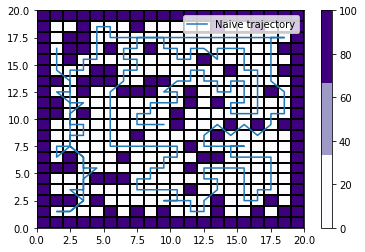

In [8]:
grid_cfg = grid_cfgs[1]
grid_to_plot = create_mock_grid(num_x_cells=grid_cfg.size,
                num_y_cells=grid_cfg.size,
                cell_size=1,
                occupancy_percentage=grid_cfg.occupancy_pct)
plot_solution(naive_results[grid_cfg], grid_to_plot, "Naive trajectory")

# Plot one of the blueprint aware trajectories

The robot should take 167 steps to explore the grid with Blueprint aware trajectory approach.


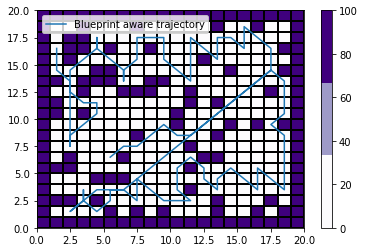

In [9]:
grid_cfg = grid_cfgs[1]
grid_to_plot = create_mock_grid(num_x_cells=grid_cfg.size,
                num_y_cells=grid_cfg.size,
                cell_size=1,
                occupancy_percentage=grid_cfg.occupancy_pct)
plot_solution(blueprint_aware_results[grid_cfg], grid_to_plot, "Blueprint aware trajectory")

In [10]:
naive_histogram = {grid_cfg: len(solution) for grid_cfg, solution in naive_results.items()}
blueprint_aware_histogram = {grid_cfg: len(solution) for grid_cfg, solution in blueprint_aware_results.items()}

In [11]:
# naive_df = pd.DataFrame(naive_histogram)
naive_histogram

{GridConfig(size=20, occupancy_pct=0): 337,
 GridConfig(size=20, occupancy_pct=20): 375,
 GridConfig(size=25, occupancy_pct=0): 653,
 GridConfig(size=25, occupancy_pct=20): 562}

# Overall performance analysis

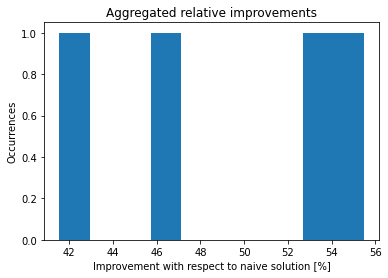

In [12]:
diff_in_solutions = {}
for cfg in naive_results:
    assert cfg in blueprint_aware_results
    diff_in_solutions[cfg] = 100 * (len(naive_results[cfg]) - len(blueprint_aware_results[cfg])) / len(naive_results[cfg])

plt.hist(list(diff_in_solutions.values()))
plt.xlabel("Improvement with respect to naive solution [%]")
plt.ylabel("Occurrences")
plt.title("Aggregated relative improvements")
plt.show()

# Evaluate performance improvement relationed to grid sizes.

In [13]:
aggregated_naive_solutions_by_size = {}
for cfg, solution in naive_results.items():
    if cfg.size in aggregated_naive_solutions_by_size:
        aggregated_naive_solutions_by_size[cfg.size] += (len(solution) / len(OCCUPANCY_PCT_TO_TEST))
    else:
        aggregated_naive_solutions_by_size[cfg.size] = (len(solution) / len(OCCUPANCY_PCT_TO_TEST))

aggregated_blueprint_aware_solutions_by_size = {}
for cfg, solution in blueprint_aware_results.items():
    if cfg in aggregated_blueprint_aware_solutions_by_size:
        aggregated_blueprint_aware_solutions_by_size[cfg.size] += (len(solution) / len(OCCUPANCY_PCT_TO_TEST))
    else:
        aggregated_blueprint_aware_solutions_by_size[cfg.size] = (len(solution) / len(OCCUPANCY_PCT_TO_TEST))

aggregated_blueprint_aware_solutions_by_size_lst = []
aggregated_naive_solutions_by_size_lst = []
for _, solution_length in sorted(aggregated_blueprint_aware_solutions_by_size.items()):
    aggregated_blueprint_aware_solutions_by_size_lst.append(solution_length)
for _, solution_length in sorted(aggregated_naive_solutions_by_size.items()):
    aggregated_naive_solutions_by_size_lst.append(solution_length)
    

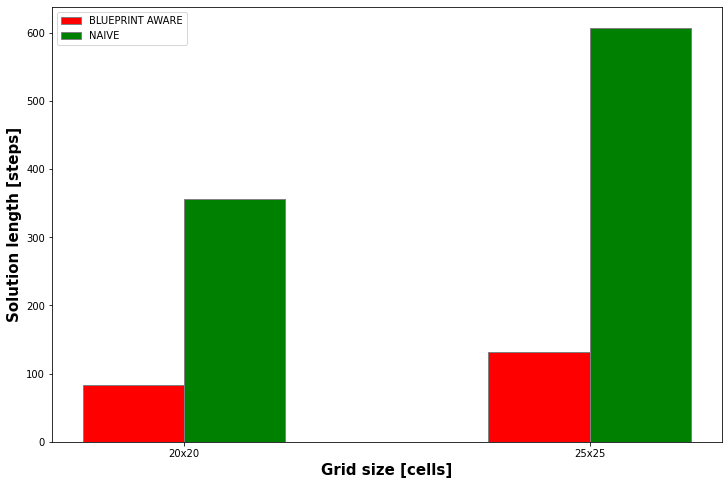

In [14]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(aggregated_naive_solutions_by_size))
br2 = [x + barWidth for x in br1]
 

# Make the plot
plt.bar(br1, aggregated_blueprint_aware_solutions_by_size_lst, color ='r', width = barWidth,
        edgecolor ='grey', label ='BLUEPRINT AWARE')
plt.bar(br2, aggregated_naive_solutions_by_size_lst, color ='g', width = barWidth,
        edgecolor ='grey', label ='NAIVE')
 
# Adding Xticks
plt.xlabel('Grid size [cells]', fontweight ='bold', fontsize = 15)
plt.ylabel('Solution length [steps]', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth / 2 for r in range(len(aggregated_blueprint_aware_solutions_by_size_lst))],
        [f"{x}x{x}" for x in GRID_SIZES])
 
plt.legend()
plt.show()

# Same with occupancy percentage

In [15]:
aggregated_naive_solutions_by_occupancy = {}
for cfg, solution in naive_results.items():
    if cfg.occupancy_pct in aggregated_naive_solutions_by_occupancy:
        aggregated_naive_solutions_by_occupancy[cfg.occupancy_pct] += (len(solution) / len(GRID_SIZES))
    else:
        aggregated_naive_solutions_by_occupancy[cfg.occupancy_pct] = (len(solution) / len(GRID_SIZES))
aggregated_blueprint_aware_solutions_by_occupancy = {}
for cfg, solution in blueprint_aware_results.items():
    if cfg in aggregated_blueprint_aware_solutions_by_occupancy:
        aggregated_blueprint_aware_solutions_by_occupancy[cfg.occupancy_pct] += (len(solution) / len(GRID_SIZES))
    else:
        aggregated_blueprint_aware_solutions_by_occupancy[cfg.occupancy_pct] = (len(solution) / len(GRID_SIZES))

aggregated_blueprint_aware_solutions_by_occupancy_lst = []
aggregated_naive_solutions_by_occupancy_lst = []
for _, solution_length in sorted(aggregated_blueprint_aware_solutions_by_occupancy.items()):
    aggregated_blueprint_aware_solutions_by_occupancy_lst.append(solution_length)
for _, solution_length in sorted(aggregated_naive_solutions_by_occupancy.items()):
    aggregated_naive_solutions_by_occupancy_lst.append(solution_length)
    

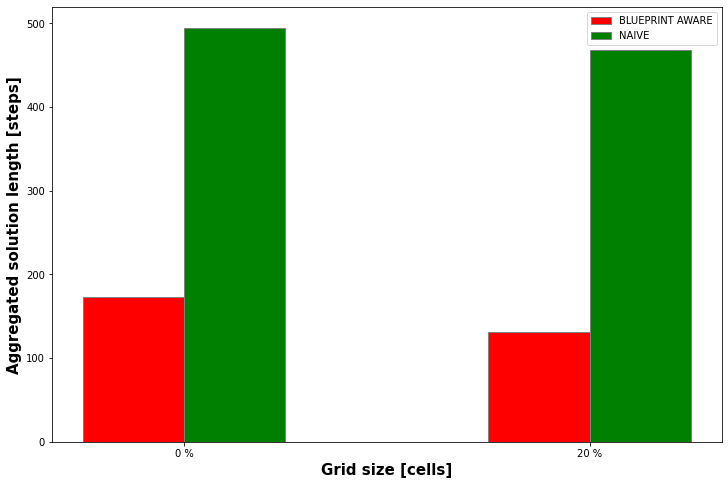

In [16]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(aggregated_naive_solutions_by_occupancy))
br2 = [x + barWidth for x in br1]
 

# Make the plot
plt.bar(br1, aggregated_blueprint_aware_solutions_by_occupancy_lst, color ='r', width = barWidth,
        edgecolor ='grey', label ='BLUEPRINT AWARE')
plt.bar(br2, aggregated_naive_solutions_by_occupancy_lst, color ='g', width = barWidth,
        edgecolor ='grey', label ='NAIVE')

 
# Adding Xticks
plt.xlabel('Grid size [cells]', fontweight ='bold', fontsize = 15)
plt.ylabel('Aggregated solution length [steps]', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth / 2 for r in range(len(aggregated_blueprint_aware_solutions_by_occupancy_lst))],
        [f"{x} %" for x in OCCUPANCY_PCT_TO_TEST])
 
plt.legend()
plt.show()